In [6]:
#Utility functions are implemented over here


#takes a Python object and saves it on the local drive for convenience
def saveToFile(obj,name):
    import pickle
    pickle.dump( obj, open(name + ".p", "wb" ))
    
    
#function to retrieve the object that was saved to a file earlier
def openFromFile(name):
    import pickle
    temporary = pickle.load( open( name + ".p", "rb" ))
    return temporary


#function to plot t-SNE graph in 2D
def plotSNE(feat, lab, name, perplex=50, iterations= 5000):
    
    #the main function for tsne
    from MulticoreTSNE import MulticoreTSNE as TSNE
    model = TSNE(n_jobs=4, verbose=2)

    tsne_data = model.fit_transform(feat).T
    

    # creating a new data fram which help us in ploting the result data
    tsne_data = np.vstack((tsne_data, lab)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    
    
    tsne_df.to_csv(name)  #we save all the resulting 2D vectors for further use
    
    
    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2',alpha=0.3).add_legend()
    plt.title("{} iterations with perplexity = {}".format(iterations, perplex))
    plt.show()



In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

"""
nltk.download('popular')

con = sqlite3.connect('./database.sqlite') 

#Only get reviews where the score is not 3
data = pd.read_sql_query("""
"""
SELECT *
FROM Reviews
WHERE Score != 3
, con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def decide(x):
    if x < 3:
        return 0
    return 1

#Apply the decide function to all the points in Score column
data['Score'] = data['Score'].map(decide) """

"\nSELECT *\nFROM Reviews\nWHERE Score != 3\n, con) \n\n\n\n\n# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.\ndef decide(x):\n    if x < 3:\n        return 0\n    return 1\n\n#Apply the decide function to all the points in Score column\ndata['Score'] = data['Score'].map(decide) "

In [12]:
print(data.shape)
data.head()
#We have 525k entries right now, this is get reduced as we clean the unnecessary entries

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
#We already know that multiple products have exact same reviews
#We also know a couple entries have Helpfullness numerator more than denominator, which is absurd, impossible. 
#We will now remove those entries and only keep one of them

#Sort the entries
sorted_Data = data.sort_values('ProductId', axis=0)

#Go through the entries, if duplicate is found, it'll keep first entry and delete the rest
final=sorted_Data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Remove entries with absurd values
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

print(final.shape)
final['Score'].value_counts()
#Our final list of entries only has 364k reviews out of which 307 are positive
#It's an imbalanced dataset
#Where as the number was much larger earlier when we had duplicate entries

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

def cleanHtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanPunctuation(sentence): #function to clean the word of any punctuation or special characters
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleantext = re.sub(r'[.|,|)|(|\|/]',r' ',cleantext)
    return  cleantext

In [15]:
#takes review text as input
def cleanThis(text):
    finalText = []
    snow = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
    stop = set(stopwords.words('english'))
    newSentence = []
    
    
    for sentence in text:
        filtered_sentence=[]
        sentence = cleanHtml(sentence) #remove HTML tags
        for word in sentence.split(): #convert the sentence into a list of words
            for cleaned_word in cleanPunctuation(word).split(): #removes the punctuations like dot, comma, exclamations, question marks, etc
                if cleaned_word.isalpha(): #only proceeds if word is alphabetic
                    if(cleaned_word.lower() not in stop): #only proceeds if word is not a stop word
                        filtered_sentence.append(cleaned_word.encode('utf8'))
                    else:
                        continue
                else:
                    continue 
        newSentence = b" ".join(filtered_sentence) 
        finalText.append(newSentence)
             
    return finalText

In [17]:
cleanedReviews = cleanThis(final["Text"].values)

In [18]:
#add one the clean reviews as a colmun in the dataset
final["cleanText"] = cleanedReviews
saveToFile(final, "finalDataset")

In [19]:
#calculate the Bag Of Words representation for each review
count_vect = CountVectorizer(ngram_range=(1,2))
bagOfWords = count_vect.fit_transform(final["cleanText"].values)
saveToFile(bagOfWords,"bow")

In [15]:
#calculate the tf-idf representation for each review

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfIdf = tf_idf_vect.fit_transform(final['cleanText'].values)
saveToFile(tfIdf, "tfidf")
saveToFile(tf_idf_vect, "tfidf2")

In [6]:
#takes array of text as input, gives array of w2v vectors(of required dimension) as output
final = openFromFile("finalDataset")
def w2v(x,n):
    
    import gensim
    import pickle
    i=0
    list_of_sentences=[]
    for sent in x:
        filtered_sentence=[]
        for w in sent.split():
            try:
                filtered_sentence.append(w.decode('ASCII'))
            except:
                continue
        list_of_sentences.append(filtered_sentence) 
        
        
    #generate w2v vectors from the list of sentences 
    w2v=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=n, workers=4)
    
    sentence_vectors = [] # the avg-w2v for each sentence/review is stored in this list

    #count of words with no vectors
    #some words will not have vectors for them as they occured less than 5 times in the dataset
    #that is why they are not important
    count = 0

    for sent in list_of_sentences: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                count += 1
        if cnt_words!= 0:
            sent_vec /= cnt_words
        sentence_vectors.append(sent_vec)
        
        
    return sentence_vectors #return array of w2v vectors for each 

w2vector = w2v(final['cleanText'].values,50)
saveToFile(w2vector,"avgw2v")

In [20]:
# TF-IDF weighted Word2Vec
list_of_sent = openFromFile("list_of_sent")
tfIdf = openFromFile("tfidf")
tfIdf2 = openFromFile("tfidf2")

tfidf_feat = tfIdf2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = tfIdf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum!= 0:
            sent_vec /= weight_sum
    tfidfw2v.append(sent_vec)
    row += 1

saveToFile(tfidfw2v, "tfidfw2v")



In [23]:
print(len(tfidfw2v[0]))
print(len(tfidfw2v))

50
364171


# t-SNE Visualizations

## 1. Bag Of Words

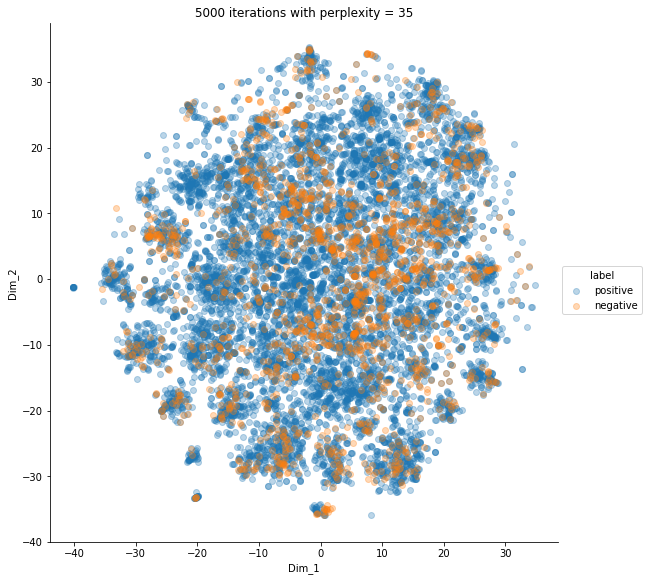

In [7]:
final = openFromFile("finalDataset") #load the dataset for scores
bow = openFromFile("bow") # open the bag of wordsrepresentation of the text that we had created earlier

#note that I have chosen not to randomize the data so that I can do time based splitting later on
# with KNN,Naive Bayes and Logistic Regression
X_train, X_test, y_train, y_test = train_test_split( bow,np.array(final["Score"]) , test_size=0.97, random_state=0)
svd_bow = TruncatedSVD(n_components=50, random_state=0)
svd_data_bow = svd_bow.fit_transform(X_train) #reduce those 2.9 million dimensions of bag of words into just 50
scaler = StandardScaler(with_mean=False)
std_bow = scaler.fit_transform(svd_data_bow) #standardize the data
saveToFile(std_bow,"std_bow") #save the transformed features for further use
plotSNE(std_bow,y_train,"bow_tSNE",35) #convert 50D into just 2D using t-SNE and then plot the points
#we have the feautres and the labels(scores), lets see what type of t-SNE plot we get out of it

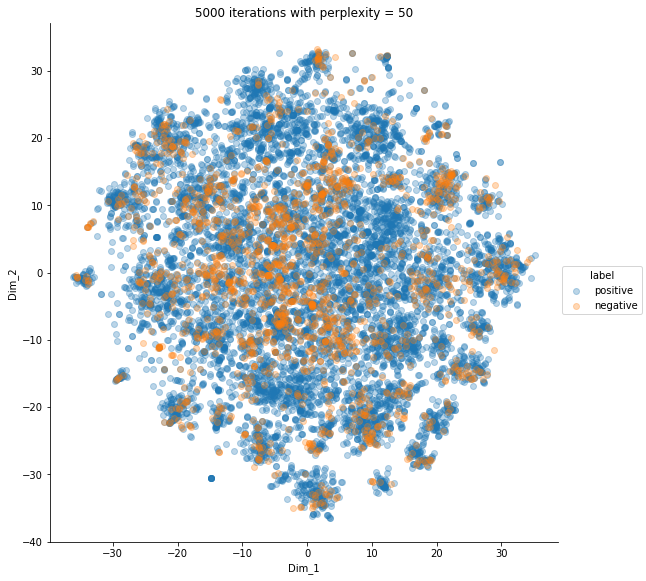

In [8]:
plotSNE(std_bow,y_train,"bow_tSNE",50)


## 2. TF-IDF

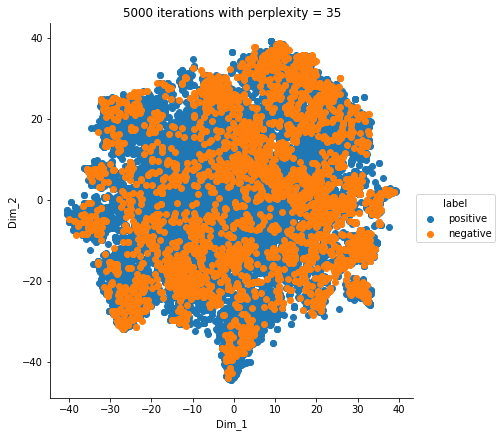

In [4]:
final = openFromFile("finalDataset") #load the dataset for scores
tfidf = openFromFile("tfidf") # open the bag of wordsrepresentation of the text that we had created earlier

#note that I have chosen not to randomize the data so that I can do time based splitting later on
# with KNN,Naive Bayes and Logistic Regression
X_train, X_test, y_train, y_test = train_test_split( tfidf,np.array(final["Score"]) , test_size=0.95, random_state=0)
svd_tfidf = TruncatedSVD(n_components=50, random_state=0)
svd_data_tfidf = svd_bow.fit_transform(X_train) #reduce those 2.9 million dimensions of bag of words into just 50
scaler = StandardScaler(with_mean=False)
std_tfidf = scaler.fit_transform(svd_data_tfidf) #standardize the data
saveToFile(std_tfidf,"std_tfidf") #save the transformed features for further use
plotSNE(std_tfidf,y_train,"tfidf_tSNE",35) #convert 50D into just 2D using t-SNE and then plot the points
#we have the feautres and the labels(scores), lets see what type of t-SNE plot we get out of it

## 3. Average Word2Vec

got the array


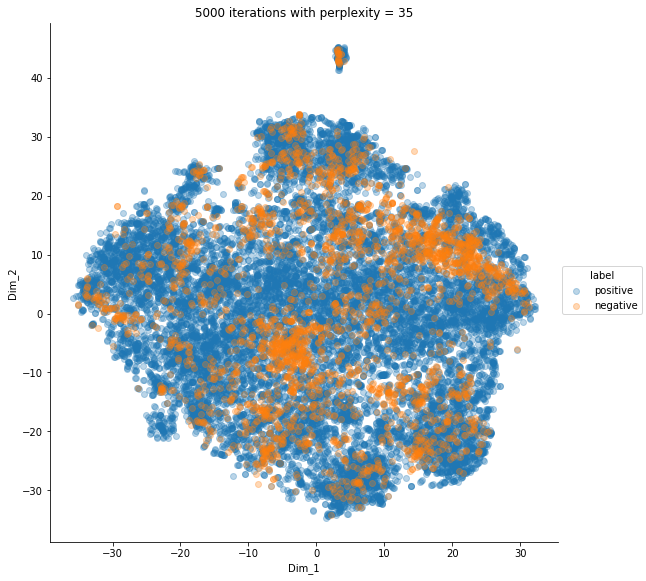

In [29]:
final = openFromFile("finalDataset") #load the dataset for scores
w2v = openFromFile("avgw2v") # open the bag of wordsrepresentation of the text that we had created earlier

#note that I have chosen not to randomize the data so that I can do time based splitting later on
# with KNN,Naive Bayes and Logistic Regression
X_train, X_test, y_train, y_test = train_test_split( w2v,np.array(final["Score"]) , test_size=0.95, random_state=0)
scaler = StandardScaler(with_mean=False)
std_w2v = scaler.fit_transform(X_train) #standardize the data
saveToFile(std_w2v,"std_w2v")
plotSNE(std_w2v,y_train,"w2v_tSNE",35) #convert 50D into just 2D using t-SNE and then plot the points
#we have the feautres and the labels(scores), lets see what type of t-SNE plot we get out of it

## 4. TF-IDF Weighted Word2Vec

got the array


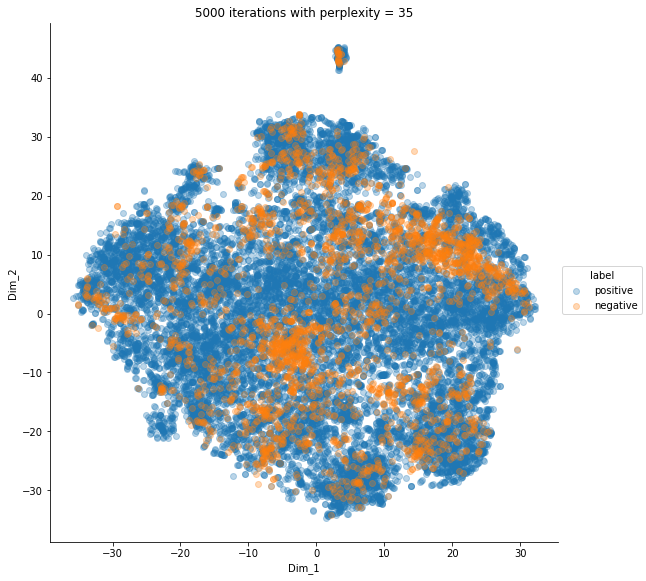

In [29]:
final = openFromFile("finalDataset") #load the dataset for scores
tfidfw2v = openFromFile("tfidfw2v") # open the bag of wordsrepresentation of the text that we had created earlier

#note that I have chosen not to randomize the data so that I can do time based splitting later on
# with KNN,Naive Bayes and Logistic Regression
X_train, X_test, y_train, y_test = train_test_split( tfidfw2v,np.array(final["Score"]) , test_size=0.95, random_state=0)
scaler = StandardScaler(with_mean=False)
std_tfidfw2v = scaler.fit_transform(X_train) #standardize the data
saveToFile(std_tfidfw2v,"std_tfidfw2v")
plotSNE(std_tfidfw2v,y_train,"tfidfw2v_tSNE",35) #convert 50D into just 2D using t-SNE and then plot the points
#we have the feautres and the labels(scores), lets see what type of t-SNE plot we get out of it